In [ ]:
!pip install pandas seaborn matplotlib
!pip install optuna
!pip install -U tqdm
!pip install scipy
!pip install pwlf

In [190]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import pwlf
import seaborn as sns

from math import tau

sns.set_style('whitegrid')

# dataset introspection

In [ ]:
D= pd.read_csv('../../../tuning_curve_samples.csv')
print(f"found {len(D) / len(D['joint'].unique())} samples")
# drop J1s but keep WRJ1. The others don't exist
D= D[
    (D['joint'] != 'FFJ1') &
    (D['joint'] != 'MFJ1') &
    (D['joint'] != 'RFJ1') &
    (D['joint'] != 'LFJ1') &
    (D['joint'] != 'THJ1')
    ]
D.describe()

found 75.0 samples


,time,position,reading
count,1.425000e+03,1425.000000,1425.000000
mean,1.718894e+09,-0.030964,1804.015439
std,1.070545e+04,0.297896,425.504371
min,1.718882e+09,-1.455418,1192.000000
25%,1.718884e+09,-0.097146,1544.000000
50%,1.718886e+09,-0.005796,1645.000000
75%,1.718906e+09,0.024859,2145.000000
max,1.718908e+09,1.562257,3292.000000


In [ ]:
# facet grid by joint
plt.figure(figsize=(15, 10), dpi=150)

# like this, but wrap in columns instead of rows
g = sns.FacetGrid(D, col='joint', col_wrap=5, height=4, sharex=False, sharey=False, hue='joint')

g.map(sns.scatterplot, 'reading', 'position', linewidth = 0)
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(plticker.MultipleLocator(100))
    # format, e.g.,  1200 as 1.2k
    ax.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, _: f'{x/1000:.1f}k'))
    # rotate labels
    for label in ax.get_xticklabels():
        label.set_rotation(60)
    ax.yaxis.set_major_locator(plticker.MaxNLocator(20))
    ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.2f'))

g.savefig(f'readings-vs-positions {pd.Timestamp.now()}.svg')

In [ ]:
# facet stripplot by joint
g = sns.FacetGrid(D, col='joint', col_wrap=5, height=4, sharex=False, sharey=False, hue='joint')
g.map(sns.stripplot, 'reading', order= None)
# g.savefig(f'stripplot-readings {pd.Timestamp.now()}.svg')

# fit piecewise linear function

In [ ]:
import pwlf
def fit(x,y,N):
    model = pwlf.PiecewiseLinFit(x, y)
    model.fit(N)
    xb = model.fit_breaks
    yb = model.predict(xb)
    return xb, yb

In [205]:
FINGER = 'LFJ4'
Df = D[D['joint'] == FINGER]

# filter broken datapoints
Df = Df[Df['position'] > -0.25]

# sort 
Df = Df.sort_values(by='reading')
x = Df['reading']
y = Df['position']
Df.describe()

,time,position,reading
count,3.600000e+01,36.000000,36.000000
mean,1.718905e+09,0.084847,1950.222222
std,2.132572e+03,0.134170,189.968586
min,1.718901e+09,-0.220361,1541.000000
25%,1.718905e+09,0.038239,1849.500000
50%,1.718906e+09,0.087570,1999.000000
75%,1.718907e+09,0.192961,2074.250000
max,1.718908e+09,0.280203,2187.000000


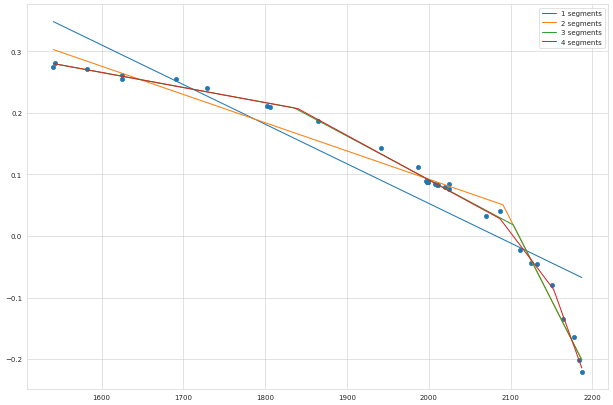

In [209]:
plt.figure(figsize=(15, 10), dpi=50)
plt.scatter(x, y)

for i in range(1, 5):
    xb,yb = fit(x,y,i)
    plt.plot(xb, yb, label=f"{i} segments")

plt.legend()
plt.show()

Copy this line to the corresponding calibration.yaml in sr_hand_config:
["LFJ4", [[1541.00, 16.05], [1840.66, 11.83], [2087.39, 1.59], [2153.10, -5.05], [2187.00, -12.29]]],


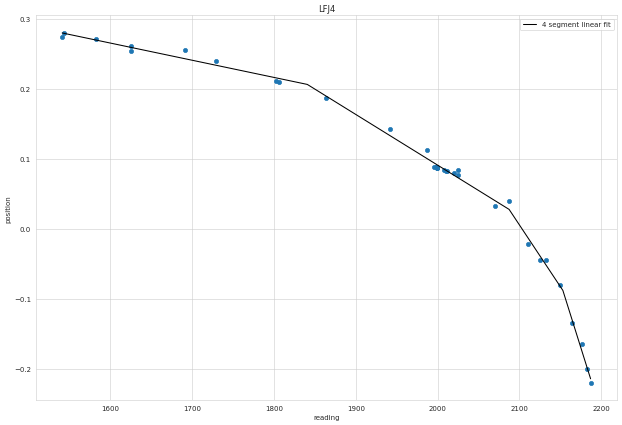

In [208]:
# hand-picked number of segments:
i = 4

xb,yb = fit(x,y,i)
plt.figure(figsize=(15, 10), dpi=50)
plt.scatter(x, y)
plt.plot(xb, yb, label=f"{i} segment linear fit", color='black')
plt.title(FINGER)
plt.xlabel('reading')
plt.ylabel('position')
plt.legend()
plt.savefig(f'{FINGER} {i} segments {pd.Timestamp.now()}.svg')

# calibration file format for shadow hand tuning curves
entries = f'["{FINGER}", [' + ", ".join([f"[{x:.2f}, {y*360/tau:.2f}]" for x,y in zip(xb,yb)]) + "]],"
print(f"Copy this line to the corresponding calibration.yaml in sr_hand_config:\n" + entries)